In [147]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.metrics import  make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from matplotlib.pyplot import *


# Preprocessing the Data in rating.csv:
def preprocessRatingFile(ratingdata):
    
    # Removing the 'timestamp' field from the ratingdata because I won't use it
    ratingdata=ratingdata.drop('timestamp', axis = 1)
    df=pd.DataFrame(ratingdata)
    # Getting a unique list of users (movie viewers)
    users=np.unique(df['userId'])
    print ("\nThe total number of unique users in the data is:  %i" %np.size(users))
    # Showing a unique sorted list of ratings which range between 0.5 to 5 and go up 0.5
    print ("\nThe original ratings in the data before preprocessing: " )
    print(np.unique(ratingdata['rating']))
    print ("\nThe number of those ratings are:  %i "%np.size(np.unique(ratingdata['rating'])))
    print ("\nA plot displaying the ratings for the first 30 records before preprocessing: ")
    fig, ax = subplots()
    df['rating'].head(50).plot(x="record",y="rating",figsize=(12, 6),kind='bar',title="ratings", ax=ax,grid=True,color=np.where(df["rating"]>=3, '#1f77b4', 'r'))
    ax.legend(["dislike"])
    # I transformed the value of the rating series into a value of either 0 "like" or 1 "dislike"
    df['rating']= df['rating'].apply(lambda x: 0 if x>=3 else 1 )
    # or 
    #df['rating']=[0 if rating >=3 else 1 for rating in df['rating']]
    
    return df, users





Sample of the data in 'rating.csv' before preprocessing
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

The feature names are:
['userId', 'movieId', 'rating', 'timestamp']


The data types of each feature is as follows:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

The total number of data rows = 100004

The total number of features in the data= 4

The Total missing values for each feature:- 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

The total number of unique users in the data is:  671

The original ratings in the data before preprocessing: 
[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]

The number of those ratings are:  10 

A plot displaying the ratings for the first 30 records before preprocessing: 


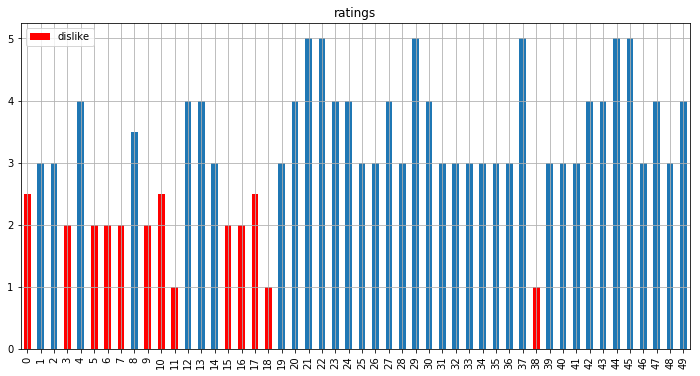

In [170]:
# Printing description of the data
# loading the 'ratings' file into ratingdata
ratingdata=pd.read_csv('ratings.csv')
# Show an example of records before preprocessing was applied
print ("\nSample of the data in 'rating.csv' before preprocessing")
print (ratingdata.head())
# Listing the attribute names
print ("\nThe feature names are:")
print (list(ratingdata))
print('\n')
# Showing the data types of each coulmn (data series)
print ("The data types of each feature is as follows:")
print(ratingdata.dtypes)
print ("\nThe total number of data rows = %i" %(ratingdata.shape[0]))
print ("\nThe total number of features in the data= %i" %(ratingdata.shape[1]))
# Total missing values for each feature
print("\nThe Total missing values for each feature:- ")
print (ratingdata.isnull().sum())
#print(ratingdata.describe())
# Preprocessing the 'rating.csv' file and returning the dataframe after preprocessing and a list of unique users.
ratingdata,users=preprocessRatingFile(ratingdata)



Sample of the data in 'rating.csv' after preprocessing
   userId  movieId  rating
0       1       31       1
1       1     1029       0
2       1     1061       0
3       1     1129       1
4       1     1172       0

A plot displaying the ratings for the first 30 records after preprocessing: 


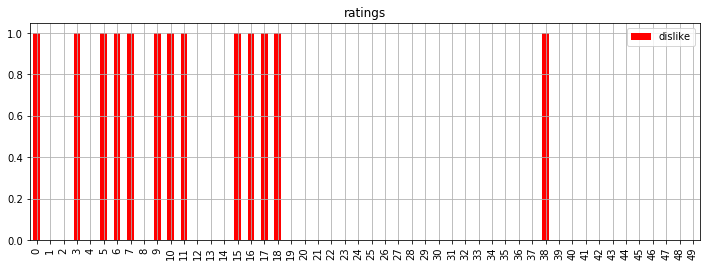

In [150]:
# Showing an example of records in 'rating.csv' after preprocessing was applied
print ("\nSample of the data in 'rating.csv' after preprocessing")
print (ratingdata.head())
print ("\nA plot displaying the ratings for the first 30 records after preprocessing: ")
fig, ax = subplots()
ratingdata['rating'].head(50).plot(x="record",y="rating",figsize=(12, 4),kind='bar',ax=ax,title="ratings", legend=True,grid=True,color=np.where(ratingdata["rating"]>=3, '#1f77b4', 'r'))
ax.legend(["dislike"])


After preprocessing the Data and discretizing the ratings into two classes like and dislike
The count of ratings with likes= 82170 
The count of ratings with dislikes= 17834 

Percentage of movies that were liked: 0.82%
Percentage of movies that were disliked: 0.18%


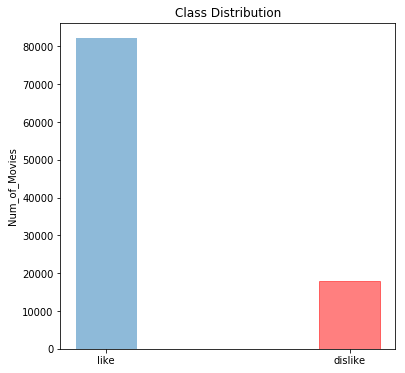

In [152]:
# Printing more description of the data

# Checking if the classes are imbalanced:
# Counting the differnt row examples in each class to check if class distribution is balanced or not
print ("\nAfter preprocessing the Data and discretizing the ratings into two classes like and dislike")
likes=(ratingdata['rating']==0).sum()
dislikes=(ratingdata['rating']==1).sum()
# or use value_counts which will automatically select the rows with each value (0, 1)and sum them for us
#likes=ratingdata['rating'].value_counts()[0]
#dislikes=ratingdata['rating'].value_counts()[1]
print ("The count of ratings with likes= %i "%likes)
print ("The count of ratings with dislikes= %i \n"%dislikes)
print ("Percentage of movies that were liked: %.2f%%" %(1.0 *likes/ratingdata.shape[0]))
print ("Percentage of movies that were disliked: %.2f%%" %(1.0 *dislikes/ratingdata.shape[0]))
# Plooting the distribution of the two classes
classes=('like','dislike')
width = 0.25       # the width of the bars
performance=[]
performance.append(likes)
performance.append(dislikes)
y_pos = np.arange(len(classes))
x=plt.bar(y_pos, performance, width,align='center', alpha=0.5)
x[1].set_color('r')
plt.xticks(y_pos, classes)
plt.ylabel('Num_of_Movies')
plt.title('Class Distribution')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size  
plt.savefig('classdistribution')
plt.show()




In [153]:
def preprocessMovieFile():
    # Load the movies data into moviedata dataFrame
    moviedata=pd.read_csv('movies.csv')
    title=moviedata['title']
    # Printig some descriptions on the movies data
    print ("The total number of movies= %i" %(moviedata.shape[0]))
    print ("\nThe total number of features in the data= %i" %(moviedata.shape[1]))
    print ("\nThe feature names are:")
    print (list(moviedata))
    # Showing the data types of each coulmn (data series)
    print ("\nThe data types of each feature is as follows:")
    print(moviedata.dtypes)
    print("\nThe Total missing values for each feature:- ")
    print (moviedata.isnull().sum())
    print ("\nSample of the movies data before preprocessing")
    print (moviedata.head())
    # Preprocessing Steps:
    # 1)
    # Extracting the movie name from the title field which if existed is at the end of the value of the field between parenthesis
    # Add a moviename column to the moviedata after extracting it from the 'title'
    moviedata['moviename']=map(lambda x: x[0:x.rfind("(")] if x.rfind("(") >-1 else x ,title)
    # 2)
    # Since the title containes a movie name + year of production we need to seperate the year from the name.
    # If a movie doesnt have a year I put a value of '1980'
    #count how many movies don't have a production year
    nonyearcount=sum([1 if x.rfind("(") == -1 else 0 for x in title])
    print "\nNumber of movies that don't have a production year= ", nonyearcount
    # Add a year column to the moviedata after extracting it from the 'title'
    moviedata['year']=map(lambda x: int(x[x.rfind("(") + 1:x.rfind("(")+5]) if x.rfind("(") >-1 else 1980 ,title)
    # 3)
    # Adding a minmaxyear column to moviedata after applying the Min-Max normalization on the year to get a value between [0, 1]
    # Applying the Min-Max normalization on the year to get a value between [0, 1]
    #min-max=(year-oldmin / (oldmax-oldmin) ) *(newmax-newmin) +newmin
    moviedata['minmaxyear']=map(lambda x: '' if x=='' else round((float((x-min(moviedata['year'])))/float((max(moviedata['year'])-min(moviedata['year']))))*(1-0)+0,3),moviedata['year'])
    # 4)
    # Adding scaledyear column to moviedata after Discretizing the year to [old, new, moderate] movie
    # which I will represent by [1, 2, 3]
    #moviedata['scaledyear']=map(lambda x: "old" if x<1980 else "moderate" if x <2000 else "new"  ,moviedata['year'])
    print ("\nInformation required to discretize the year of the movies")
    print ("The maximum year %i" %max(moviedata['year']))
    print ("The minimum year %i" %min(moviedata['year']))
    print ("The middle year %i" %math.floor(np.median(moviedata['year'])))
    moviedata['scaledyear']=map(lambda x: 1 if x<1991 else 2 if x <2000 else 3  ,moviedata['year'])
    # 5)
    # Preparing the genra field for the one-hot-code encoding
    # Extracting the unique different genre values
    # Counting the number of different genres and removing the (no genres listed) value
    genre=moviedata['genres']
    # print (genre)
    genrelist=[]
    for g in genre:
        x=g.split("|")
        for i in x:
            if i not in genrelist:
                genrelist.append(i)
    genrelist.remove('(no genres listed)')
    print("\nThe different genres for the movies are: ")
    print(genrelist)
    print ("\nThe number of unique genres are:  %i" %np.size(np.unique(genrelist)))

    # Performing one hot code encodig for genre column
    # Adding 19 columns to the data frame which are the number of unique different genres
    # take note that we can'nt represent the 19 columns with 18 because the genre takes multiple values
    for g in genrelist:
        moviedata[g]=map(lambda x: 1 if g in x else 0,moviedata['genres'])
    return moviedata,genrelist




In [6]:
# Preprocessing the 'movies.csv' file and returning the 'moviedata' data frame and the unique list of the 19 different genres
moviedata,genrelist=preprocessMovieFile()

# Showing an example of records after preprocessing was applied
print ("\nSample of the moviedata after preprocessing")
print (moviedata.head())

The total number of movies= 9125

The total number of features in the data= 3

The feature names are:
['movieId', 'title', 'genres']

The data types of each feature is as follows:
movieId     int64
title      object
genres     object
dtype: object

The Total missing values for each feature:- 
movieId    0
title      0
genres     0
dtype: int64

Sample of the movies data before preprocessing
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Number of 

   rating  movieId         moviename  scaledyear  Adventure  Animation  \
0       1       31  Dangerous Minds            2          0          0   
1       0       31  Dangerous Minds            2          0          0   
2       0       31  Dangerous Minds            2          0          0   

   Children  Comedy  Fantasy  Romance    ...      Thriller  Horror  Mystery  \
0         0       0        0        0    ...             0       0        0   
1         0       0        0        0    ...             0       0        0   
2         0       0        0        0    ...             0       0        0   

   Sci-Fi  Documentary  IMAX  War  Musical  Western  Film-Noir  
0       0            0     0    0        0        0          0  
1       0            0     0    0        0        0          0  
2       0            0     0    0        0        0          0  

[3 rows x 23 columns]


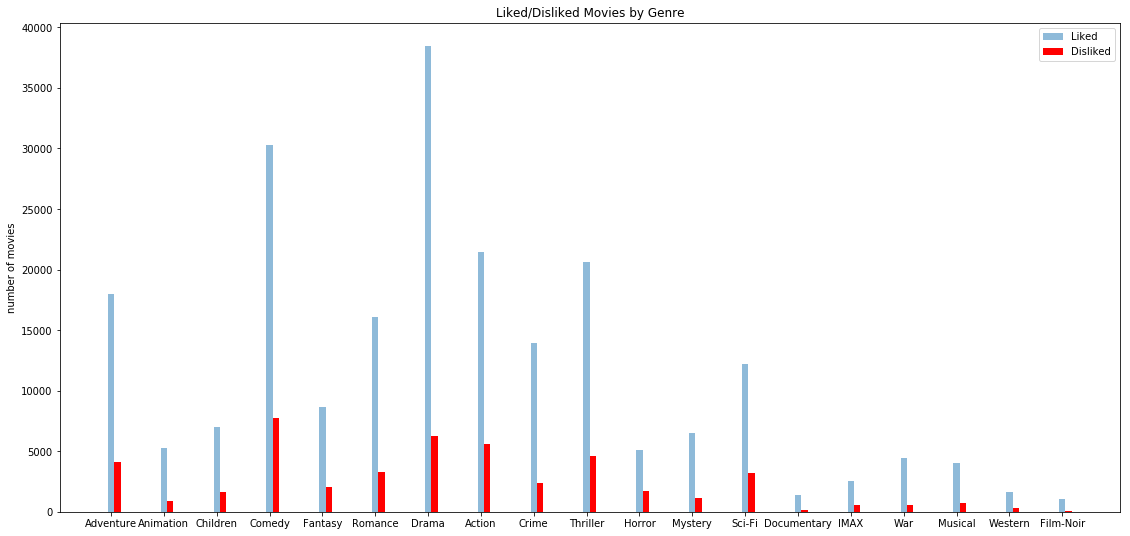

In [155]:
# Plotting the distribution of likes and dislikes of movies based on the genre
# Creating a Data Frame that contains the movieId and rating along with the genre of the movie.
bigdata=ratingdata[[ 'rating','movieId']].merge(moviedata[['moviename','scaledyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner')
# Printing sample of the data e.g.e the first three rows
print (bigdata.head(3))

glike=[]
gdislike=[]
# Selecting the records were the movies were liked
liked=bigdata[bigdata['rating']==0]
# Selecting the records were the movies were disliked
disliked=bigdata[bigdata['rating']==1]
# Counting the number of movies that was liked and disliked for each movie genre
for g in genrelist:
    glike.append((liked[g]==1).sum())
    gdislike.append((disliked[g]==1).sum())

# Plotting the number of movies that was liked and disliked for each movie genre    
glikes = np.array(glike)
gdislikes = np.array(gdislike)
genres=np.array(genrelist)
x=list(range(0,19))
x=[i*5 for i in x]
ind = np.array(x)
width=0.60       
plt.bar(ind, glikes, width, label='Liked',alpha=0.5)
plt.bar(ind + width, gdislikes, width,label='Disliked',color='r')

plt.ylabel('number of movies')
plt.title('Liked/Disliked Movies by Genre')

plt.xticks(ind , genres)
plt.legend(loc='best')
fig_size = plt.rcParams["figure.figsize"]
 

fig_size[0] = 19
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size 
#print "Current figure size:", fig_size
plt.savefig('genres')
plt.show()



In [43]:
# Printing the genres based on the most watched movies with those genres
sorted_genrelist=sorted(zip(glike, genrelist), key=lambda pair: pair[0],reverse=True)
print("Printing the genres starting with the genre that has the highest amount of watched movies and ending with the least:- \n")
for genre in sorted_genrelist:print (genre[1], genre[0])

Printing the genres starting with the genre that has the highest amount of watched movies and ending with the least:- 

('Drama', 38462)
('Comedy', 30275)
('Action', 21483)
('Thriller', 20638)
('Adventure', 17939)
('Romance', 16042)
('Crime', 13907)
('Sci-Fi', 12187)
('Fantasy', 8633)
('Children', 7018)
('Mystery', 6469)
('Animation', 5265)
('Horror', 5110)
('War', 4436)
('Musical', 4027)
('IMAX', 2567)
('Western', 1612)
('Documentary', 1395)
('Film-Noir', 1050)


In [44]:
# Getting the names of the movies that was watched the most and watched the least
movienames=[]
movienames=list(bigdata['moviename'])
uniquemovienames=[]
for movie in movienames:
    if movie not in uniquemovienames:
        uniquemovienames.append(movie)


moviecount=[]
for  movie in uniquemovienames:
    moviecount.append((bigdata['moviename']==movie).sum())
    
maxapperance=max(moviecount)
maxmovielist=[]
minmovielist=[]
for i in range(0,len(uniquemovienames)):
    if moviecount[i]==maxapperance:
        maxmovielist.append(uniquemovienames[i])
    if moviecount[i]==1:
        minmovielist.append(uniquemovienames[i])  

print("The movie that was watched the most is:%s it was watched by %i user(s)" %(maxmovielist[0],maxapperance))
print("There are  %i movies that were watched %i time" %(len(minmovielist), min(moviecount)))


The movie that was watched the most is:Forrest Gump  it was watched by 341 user(s)
There are  2945 movies that were watched 1 time


In [62]:
# Printing the names of the movies and the number of their views
bigdata['moviename'].value_counts()

Forrest Gump                                                                                                                                       341
Pulp Fiction                                                                                                                                       324
Shawshank Redemption, The                                                                                                                          311
Silence of the Lambs, The                                                                                                                          304
Star Wars: Episode IV - A New Hope                                                                                                                 291
Jurassic Park                                                                                                                                      274
Matrix, The                                                                                   

In [45]:
# Getting the names of the movie that was liked the most.

likedcount=[]
movielist1=[]
for  movie in uniquemovienames:
    likedcount.append((liked['moviename']==movie).sum())

maxliked=max(likedcount) 
for i in range(0,len(uniquemovienames)):
    if likedcount[i]==maxliked:
        movielist1.append(uniquemovienames[i])
    

print("The movie that was liked the most among the other movies is %s" %movielist1[0])


The movie that was liked the most among the other movies is Forrest Gump 


Current figure size: [6, 6]


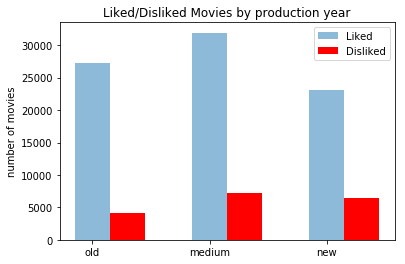

In [46]:
# Plotting the distribution of likes and dislikes of movies based on the production year of the movie
movietype=('old','medium','new')
mlike=[]
mdislike=[]
for i in range(1,4):
    mlike.append((liked['scaledyear']==i).sum())
    mdislike.append((disliked['scaledyear']==i).sum())

    
mlikes = np.array(mlike)
mdislikes = np.array(mdislike)
x=list(range(0,3))
x=[i*2 for i in x]
ind = np.array(x)
width=.60       
plt.bar(ind, mlikes, width, label='Liked',alpha=0.5)
plt.bar(ind + width, mdislikes, width,label='Disliked', color='r')

plt.ylabel('number of movies')
plt.title('Liked/Disliked Movies by production year')

plt.xticks(ind , movietype)
plt.legend(loc='best')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size 
print "Current figure size:", fig_size
plt.savefig('class by year')
plt.show()



In [215]:
def fit_model(X_train, y_train,X_test, y_test,av):
    """ Performs grid search over the best 'max_depth' parameter for a
        decision tree classifier trained on the input data [X, y]. """

    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.10, random_state = 0)

    # Initializing a decision tree classifier object
    model = DecisionTreeClassifier(random_state=0)

    # Creating a dictionary for the parameter 'max_depth' with a range from 1 to 22
    dt_range = range(1, 22)
    params = dict(max_depth=dt_range)


    # Creating the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(model, params,scoring=None, cv=cv_sets)
    # Fit the grid search object to the training data to compute the optimal model
    # Calculating time to fit the DT model
    t0=time()
    grid = grid.fit(X_train, y_train)
    trainingTime=round(time()-t0,3)
    
    # Getting Predictions
    # Calculating time to predict the labels using the DT model
    t0=time()
    y_pred = grid.predict(X_test)
    predictionTime=round(time()-t0,3)
    # Returning recall, precision and recall and the gridsearch's best parameters
    return (round(recall_score(y_test, y_pred, average=av),2)), (round(precision_score(y_test, y_pred, average=av),2)),(round(f1_score(y_test, y_pred, average=av),2)),grid.best_estimator_,trainingTime,predictionTime




def DT(av,ratings,DTdata):
    
    ###
    # Splitting the features and target class into training data and testing data
    X_train, X_test, y_train, y_test = train_test_split(DTdata, ratings, test_size=0.2, random_state=0)
    # Calling the Decision Tree function
    DTrecall,DTprecision,DTf1score,estim,trainingTime,predictionTime=fit_model(X_train, y_train,X_test,y_test,av)
    
    ###
    # Returning recall, precision and recall and the gridsearch's best parameters
    return DTrecall,DTprecision,DTf1score,estim,trainingTime,predictionTime



In [ ]:
f1scores=[0,0,0,0] #this will contain the maximum f1 score for each of the models

In [217]:

listofDTf1scores=[] #will contain 2 f1 scores for the DT model
print("Preparing the data for the DT classifier by merging the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns")
DTdata=pd.DataFrame(ratingdata[['userId', 'rating','movieId']].merge(moviedata[['scaledyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner'))
# Preparing the data into target class (ratings) and the features
# Selecting Target class (ratings)
ratings=DTdata['rating']
# Getting rid of the irrelevant features by dropping them
DTdata.drop(['movieId','rating'],axis=1, inplace=True)
#del DTdata['rating']
#del DTdata['movieId']
# Decision Tree Classiifer
DTrecall,DTprecision,DTf1score,reg,trainingTime,predictionTime=DT('micro',ratings,DTdata)
# Printing the max_depth value that produces the highest F1 score
#printing the max_depth value that produces the highest F1 scores using type of averaging performed on the data ='weighted'
# Calculate metrics globally by counting the total true positives, false negatives and false positives. 
print ("Calculating the metrics using average='micro'")
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))
#storing the f1 score:

listofDTf1scores.append(DTf1score)
print("Using the Decission Tree Classifier, the Recall Score= %.2f " %DTrecall)
print("Using the Decission Tree Classifier, the Precision Score= %.2f " %DTprecision)
print("Using the Decission Tree Classifier, the F1 Score= %.2f " %DTf1score)
print "Training time for the DT classifier = ", trainingTime, " s"
print "Prediction time for the DT classifier = ", predictionTime, " s"
print('')

DTrecall,DTprecision,DTf1score,reg,trainingTime,predictionTime=DT('weighted',ratings,DTdata)
#printing the max_depth value that produces the highest F1 scores using type of averaging performed on the data ='weighted'
# which Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). 
print ("Calculating the metrics using average='weighted'")
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))
#storing the f1 score:
listofDTf1scores.append(DTf1score)
f1scores[0]=max(listofDTf1scores)
print("Using the Decission Tree Classifier, the Recall Score= %.2f " %DTrecall)
print("Using the Decission Tree Classifier, the Precision Score= %.2f " %DTprecision)
print("Using the Decission Tree Classifier, the F1 Score= %.2f " %DTf1score)
print "Training time for the DT classifier = ", trainingTime, " s"
print "Prediction time for the DT classifier = ", predictionTime, " s"


Preparing the data for the DT classifier by merging the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
Calculating the metrics using average='micro'
Parameter 'max_depth' is 9 for the optimal model.
Using the Decission Tree Classifier, the Recall Score= 0.83 
Using the Decission Tree Classifier, the Precision Score= 0.83 
Using the Decission Tree Classifier, the F1 Score= 0.83 
Training time for the DT classifier =  36.065  s
Prediction time for the DT classifier =  0.003  s

Calculating the metrics using average='weighted'
Parameter 'max_depth' is 9 for the optimal model.
Using the Decission Tree Classifier, the Recall Score= 0.83 
Using the Decission Tree Classifier, the Precision Score= 0.78 
Using the Decission Tree Classifier, the F1 Score= 0.77 
Training time for the DT classifier =  36.986  s
Prediction time for the DT classifier =  0.003  s


In [228]:
total_fit_time=0
total_predict_time=0
def KNN(userNNdata, ratings,av):
    global total_fit_time,total_predict_time
    # Instantiating a KNN classifier 
    neigh = KNeighborsClassifier(n_neighbors=5,weights='uniform')
    X_train, X_test, y_train, y_test = train_test_split(userNNdata, ratings, test_size=0.2, random_state=0)
    # Fitting the model on the training data
    # Calculating time to fit the KNN model
    t0=time()
    neigh.fit(X_train, y_train)
    total_fit_time+=time()-t0
    # Getting Predictions by the model for the testing data
    # Calculating time to predict labels using the KNN model
    t0=time()
    y_pred = neigh.predict(X_test)
    total_predict_time+=time()-t0
    # Returning recall, precision and recall
    return f1_score(y_test, y_pred, average=av), recall_score(y_test, y_pred, average=av),precision_score(y_test, y_pred, average=av)


def KNNclassifier(users,av,NNdata):
    global total_fit_time,total_predict_time
    
    # Calling the function KNN
    f1score=0
    recal=0
    precisio=0
    for u in users:
        userId=u
        # Selecting all the rows related to the user under consideration
        userNNdata=NNdata.loc[NNdata['userId'] == userId]
        # Preparing the target data
        ratings=userNNdata['rating']
        # Removing irrelevant  
        del userNNdata['rating']
        del userNNdata['userId']
        score,recall,precision=KNN(userNNdata, ratings,av)
        f1score+=score
        recal+=recall
        precisio+=precision
    
    return  (round((float(recal)/len(users)),2)),(round((float(precisio)/len(users)),2)),(round((float(f1score)/len(users)),2))   
    


In [229]:
listofKNNf1scores=[] #will contain 2 f1 scores for the KNN model
print("Preparing the data for the KNN classifier by merging the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns")
NNdata=ratingdata[['userId', 'rating','movieId']].merge(moviedata[['minmaxyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner')
# Deleting irrelevant attribute
#del NNdata['movieId']
NNdata.drop(['movieId'],axis=1,inplace=True)
# K Nearest Nieghour Classifier
KNNrecall,KNNprecision,KNNf1score=KNNclassifier(users, 'micro',NNdata)
# Storing the f1 score
listofKNNf1scores.append(KNNf1score)

print(" ")
print ("Calculating the metrics using average='micro'")
print ("Using The K Nearest Neighbour Classifier, the  Recall Score = %.2f" %(KNNrecall))
print ("Using The K Nearest Neighbour Classifier, the  Precision Score = %.2f" %(KNNprecision))
print ("Using The K Nearest Neighbour Classifier, the  F1 Score = %.2f" %(KNNf1score))
print "Training time for the KNN classifier = ", round(total_fit_time,3), " s"
print "Prediction time for the KNN classifier = ", round(total_predict_time,3), " s" 
print ("")

total_fit_time=0
total_predict_time=0
KNNrecall,KNNprecision,KNNf1score=KNNclassifier(users, 'weighted',NNdata)
# Storing the f1 score
listofKNNf1scores.append(KNNf1score)
f1scores[1]=max(listofKNNf1scores)
print(" ")
print ("Calculating the metrics using average='weighted'")
print ("Using The K Nearest Neighbour Classifier, the  Recall Score = %.2f" %(KNNrecall))
print ("Using The K Nearest Neighbour Classifier, the  Precision Score = %.2f" %(KNNprecision))
print ("Using The K Nearest Neighbour Classifier, the  F1 Score = %.2f" %(KNNf1score))
print "Training time for the KNN classifier = ", round(total_fit_time,3), " s"
print "Prediction time for the KNN classifier = ", round(total_predict_time,3), " s" 

Preparing the data for the KNN classifier by merging the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
 
Calculating the metrics using average='micro'
Using The K Nearest Neighbour Classifier, the  Recall Score = 0.85
Using The K Nearest Neighbour Classifier, the  Precision Score = 0.85
Using The K Nearest Neighbour Classifier, the  F1 Score = 0.85
Training time for the KNN classifier =  0.297  s
Prediction time for the KNN classifier =  0.529  s

 
Calculating the metrics using average='weighted'
Using The K Nearest Neighbour Classifier, the  Recall Score = 0.85
Using The K Nearest Neighbour Classifier, the  Precision Score = 0.80
Using The K Nearest Neighbour Classifier, the  F1 Score = 0.82
Training time for the KNN classifier =  0.309  s
Prediction time for the KNN classifier =  0.547  s


In [193]:
print(f1scores)

[0.83, 0.85, 0.81, 0.79]


In [230]:
def Rforest(ratings,RFdata,av):
    
    # Splitting the features and target class into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(RFdata, ratings, test_size=0.2)

    # For increasing the F1-score, I tuned the parameters by adding max_features=None the default is 'auto', so the score increased from 
    #79% to 80%
    # and increasing the number of jobs from 2 to 10 increased the score to 81%
    # Instantiating the model
    clf = RandomForestClassifier(n_jobs=10,max_features=None)
    # Fitting the model to the training data
    # Calculating time to fit the Random Forest model
    t0=time()
    clf.fit(X_train, y_train)
    total_fit_time=round(time()-t0,3)
    
    # Getting predictions on the testing set
    # Calculating time to Predict the Random Forest model
    t0=time()
    y_pred=clf.predict(X_test)
    total_predict_time=round(time()-t0,3)
    
    # Returning Precision, Recall and F1 score
    return (round(recall_score(y_test, y_pred, average=av),2)),(round(precision_score(y_test, y_pred, average=av),2)),(round(f1_score(y_test, y_pred, average=av),2)),total_fit_time,total_predict_time
    


In [232]:
listofRFf1scores=[] #will contain 2 f1 scores for the Random Froest model
print("Preparing the data for the Random Forest Classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns")
#DTdata=pd.DataFrame(ratingdata.set_index('movieId').join(moviedata.set_index('movieId')))
RFdata=pd.DataFrame(ratingdata[['userId', 'rating','movieId']].merge(moviedata[['scaledyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner'))
#DTdata.drop('movieId', axis=1)
# Preparing the data into target class (ratings) and the features
# Selecting Target class (ratings)
ratings=RFdata['rating']
#del RFdata['movieId']
#del RFdata['rating']
RFdata.drop(['movieId','rating'],axis=1, inplace=True)
# Random Forest Classifier
RFrecall,RFprecision,RFf1score,total_fit_time,total_predict_time=Rforest(ratings,RFdata,av='micro')
# Storing the f1 score
listofRFf1scores.append(RFf1score)

print ("\nCalculating the metrics using average='micro'")
print("\nUsing the Random Forest Classifier, the Recall Score= %.2f " %(RFrecall))
print("Using the Random Forest Classifier, the Precision Score= %.2f " %(RFprecision))
print("Using the Random Forest Classifier, the F1 Score= %.2f " %(RFf1score))
print "Training time for the Random Forest classifier = ", total_fit_time, " s"
print "Prediction time for the Random Forest classifier = ", total_predict_time , " s"
print("")


RFrecall,RFprecision,RFf1score,total_fit_time,total_predict_time=Rforest(ratings,RFdata,av='weighted')
# Storing the f1 score
listofRFf1scores.append(RFf1score)
f1scores[2]=max(listofRFf1scores)

print ("Calculating the metrics using average='weighted'")
print("\nUsing the Random Forest Classifier, the Recall Score= %.2f " %(RFrecall))
print("Using the Random Forest Classifier, the Precision Score= %.2f " %(RFprecision))
print("Using the Random Forest Classifier, the F1 Score= %.2f " %(RFf1score))
print "Training time for the Random Forest classifier = ", total_fit_time, " s"
print "Prediction time for the Random Forest classifier = ", total_predict_time , " s"
print("")



Preparing the data for the Random Forest Classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns

Calculating the metrics using average='micro'

Using the Random Forest Classifier, the Recall Score= 0.81 
Using the Random Forest Classifier, the Precision Score= 0.81 
Using the Random Forest Classifier, the F1 Score= 0.81 
Training time for the Random Forest classifier =  1.381  s
Prediction time for the Random Forest classifier =  0.117  s

Calculating the metrics using average='weighted'

Using the Random Forest Classifier, the Recall Score= 0.80 
Using the Random Forest Classifier, the Precision Score= 0.78 
Using the Random Forest Classifier, the F1 Score= 0.79 
Training time for the Random Forest classifier =  1.355  s
Prediction time for the Random Forest classifier =  0.162  s



In [194]:
print(f1scores)

[0.83, 0.85, 0.81, 0.79]


In [191]:
#LightGBM is a gradient boosting framework that uses tree based learning algorithms.
def lightGBM(ratingdata,users,av):
    #### LightGBM
    total_fit_time=0
    total_predict_time=0
    lgbmdata=ratingdata[['userId', 'rating','movieId']].merge(moviedata[['minmaxyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner')
    totalrecall=0
    totalprecision=0
    totalfscore=0
    for u in tqdm(users):
        userId=u
        # Selecting the rows for the user under consideration
        Tlgbmdata=lgbmdata.loc[lgbmdata['userId'] == userId]
        # Preparing the target data
        ratings=Tlgbmdata['rating']
        # Removing irrelevant features
        del Tlgbmdata['movieId']
        del Tlgbmdata['rating']
        del Tlgbmdata['userId']
  
        userf1=0
        userprecision=0
        userrecall=0
        for i in range(0,10):
            X_train, X_test, y_train, y_test = train_test_split(Tlgbmdata, ratings, test_size=0.2)
            # Converting the training data into LightGBM dataset format
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)
            d_train = lgb.Dataset(X_train, label=y_train)
            params = {}
            params['learning_rate'] = 0.003
            params['boosting_type'] = 'gbdt'
            params['objective'] = 'binary'
            params['metric'] = 'binary_logloss'
            params['sub_feature'] = 0.8
            params['num_leaves'] = 20
            params['max_depth'] = -1
            params['min_data_in_leaf']=5
            
            t0=time()
            clf = lgb.train(params, d_train, 100)
            total_fit_time+=time()-t0

            # Prediction
            t0=time()
            y_pred=clf.predict(X_test)
            total_predict_time+=time()-t0
            #since the output of the LightGBM is a probability list each number specifiing the probability of belonging
            #to a class or not.
            #I will traverse each output and transform the probability to belong to one of the classes [0 or 1]
            #I set the threshold to 0.5, if the output is higher or equal to 0.5 I will assume the user liked the movie,
            #otherwise i will assume he didnt like it.
            y_predList=[]
            for y in y_pred:
                if y<0.5:       # setting threshold to 0.5
                    y_predList.append(0)
                else:
                    y_predList.append(1)
                

            #Confusion matrix
            cm = confusion_matrix(y_test, y_predList)
            accuracy=f1_score(y_predList,y_test, average=av)
            userf1+=accuracy
            userrecall+=recall_score(y_predList,y_test, average=av)
            userprecision+=precision_score(y_predList,y_test, average=av)

        userf1/=10
        userrecall/=10
        userprecision/=10
        totalfscore+=userf1
        totalrecall+=userrecall
        totalprecision+=userprecision
    print "Training time for the lightGBM classifier = ", round(total_fit_time,3), " s"
    print "Prediction time for the lightGBM classifier = ", round(total_predict_time,3), " s"   
    
    return (round(totalrecall/len(users),2)),(round(totalprecision/len(users),2)),(round(totalfscore/len(users),2))


In [192]:
listofLightGBMf1scores=[] #will contain 2 f1 scores for the LightGBM model


# LightGBM Classifier
Lrecall,Lprecision,Lf1score=lightGBM(ratingdata,users,av='micro')

# Storing the f1 score
listofLightGBMf1scores.append(Lf1score)

print(" ")
print ("Calculating the metrics using average='micro'")
print ("Using the LightGBM, the Recall Score =%.2f" %Lrecall)
print ("Using the LightGBM, the F1 Precision =%.2f" %Lprecision)
print ("Using the LightGBM, the F1 Score =%.2f" %Lf1score)

#
Lrecall,Lprecision,Lf1score=lightGBM(ratingdata,users,av='weighted')

# Storing the f1 score
listofLightGBMf1scores.append(Lf1score)
f1scores[3]=max(listofLightGBMf1scores)


print(" ")
print ("Calculating the metrics using average='weighted'")
print ("Using the LightGBM, the Recall Score =%.2f" %Lrecall)
print ("Using the LightGBM, the F1 Precision =%.2f" %Lprecision)
print ("Using the LightGBM, the F1 Score =%.2f" %Lf1score)





Training time for the lightGBM classifier =  228.194  s
Prediction time for the lightGBM classifier =  2.659  s
 
Calculating the metrics using average='micro'
Using the LightGBM, the Recall Score =0.76
Using the LightGBM, the F1 Precision =0.76
Using the LightGBM, the F1 Score =0.76



Training time for the lightGBM classifier =  216.898  s
Prediction time for the lightGBM classifier =  2.641  s
 
Calculating the metrics using average='weighted'
Using the LightGBM, the Recall Score =0.76
Using the LightGBM, the F1 Precision =0.86
Using the LightGBM, the F1 Score =0.79


In [195]:
# Comparing the F1-Score of the four models
classes=('Decision Tree','K Nearest Neighbour','Random Forest','LightGBM')
print("The model that scored the highest F1-Score is %s with a score of  = %.0f%%"
      %(classes[f1scores.index(max(f1scores))], max(f1scores)*100))

The model that scored the highest F1-Score is K Nearest Neighbour with a score of  = 85%


In [197]:
print(f1scores)
f1scores.append(0) # for the Collaborative Filtering

[0.83, 0.85, 0.81, 0.79]


Current figure size: [8, 4]


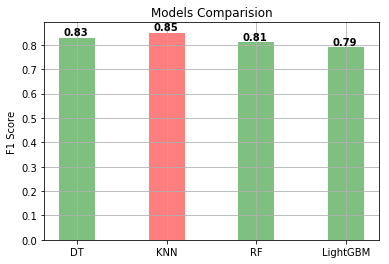

In [138]:
# Plooting the distribution of the f1 score of the four models that I trained
classes=('DT','KNN','RF','LightGBM')
width = 0.40       # the width of the bars
y_pos = np.arange(len(classes))
plt.bar(y_pos, f1scores, width,align='center', color= ['g'if x<max(f1scores) else 'r' for x in f1scores] ,alpha=0.5)
plt.xticks(y_pos, classes)
plt.grid()
plt.ylabel('F1 Score')
plt.title('Models Comparision')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size 
print "Current figure size:", fig_size
plt.savefig('my model comparision')

# To add percentages on top of the bars
for i, v in enumerate(f1scores):
    plt.text(i-0.15  ,v+0.01 , str(v), color='black', fontweight='bold')
plt.show()



In [198]:
def userCollaborativeFiltering():
# First I will create a dictionary with the preferences of each of the 671 users
# I am reading the ratings.csv file and I will leave the rating field as is with no discretization
    ratingdata=pd.read_csv('ratings.csv')
    preferences={}
    for index, record in ratingdata.iterrows():
        if int(record['userId']) in preferences.keys():
            preferences[int(record['userId'])][int(record['movieId'])]=int(record['rating'])
        else:
            preferences[int(record['userId'])] = {}
            preferences[int(record['userId'])][int(record['movieId'])]=int(record['rating'])
    return preferences

# Second I will calculate the similarity score between each user to those who rated the same movies with the user using a Euclidean distance score
def sim_distance(preferences,user1,user2):
    # Get the list of shared_items
    si={}
    for item in preferences[user1]:
        if item in preferences[user2]:
            si[item]=1
    # if they have no ratings in common, return 0
    if len(si)==0:
        return 0
    # Add up the squares of all the differences
    sum_of_squares=sum([pow(preferences[user1][item]-preferences[user2][item],2)
                      for item in si.keys()])

    return 1.0/(1.0+sum_of_squares)




In [199]:
# The benchmark model "User-Based Collaborative Filtering"
# first I will create a dictionary with the preferences of each of the 671 users
preferences=userCollaborativeFiltering()
print (preferences)

{1: {1953: 4, 1339: 3, 1061: 3, 2150: 3, 1287: 2, 2193: 2, 1129: 2, 3671: 3, 1293: 2, 1263: 2, 1343: 2, 1172: 4, 2294: 2, 2455: 2, 2968: 1, 2105: 4, 1371: 2, 31: 2, 1405: 1, 1029: 3}, 2: {515: 4, 261: 4, 265: 5, 10: 4, 527: 4, 144: 3, 17: 5, 405: 2, 150: 5, 537: 4, 485: 3, 153: 4, 410: 3, 367: 3, 497: 3, 161: 3, 539: 3, 292: 3, 165: 3, 550: 3, 39: 5, 168: 3, 551: 5, 300: 3, 500: 4, 47: 4, 50: 4, 52: 3, 350: 4, 585: 5, 185: 3, 186: 3, 509: 4, 266: 5, 62: 3, 319: 1, 272: 3, 454: 4, 552: 3, 457: 3, 586: 3, 587: 3, 588: 3, 589: 5, 590: 5, 208: 3, 593: 3, 339: 3, 468: 4, 592: 5, 474: 2, 314: 4, 222: 5, 223: 1, 480: 4, 225: 3, 356: 3, 357: 3, 273: 4, 616: 3, 235: 3, 364: 3, 720: 4, 110: 4, 317: 2, 296: 4, 370: 2, 371: 3, 372: 3, 349: 4, 248: 3, 377: 3, 508: 4, 253: 4, 382: 3, 661: 4}, 3: {2694: 3, 778: 4, 267: 3, 84236: 4, 2318: 4, 527: 3, 50068: 4, 2841: 4, 8636: 3, 2716: 3, 44191: 3, 5669: 3, 296: 4, 2858: 4, 3243: 3, 1580: 3, 1197: 5, 8622: 3, 3510: 4, 1721: 4, 1210: 3, 60: 3, 318: 5, 585

In [200]:
# Second I will calculate the similarity score between each user to those who rated the same movies with the user using a Euclidean distance score
similarity={}
for i in tqdm(range(0,len(users))):
    for user2 in users[i+1:]:
        score=sim_distance(preferences,users[i],user2)
        if int(users[i]) in similarity.keys():
            similarity[int(users[i])][int(user2)]=score 
        else:
            similarity[int(users[i])]={}
            similarity[int(users[i])][int(user2)]=score             


In [143]:
print (similarity[660])

{661: 0.3333333333333333, 662: 0.2, 663: 0.038461538461538464, 664: 0.023255813953488372, 665: 0.03225806451612903, 666: 0.045454545454545456, 667: 0.25, 668: 0.038461538461538464, 669: 0.3333333333333333, 670: 0.03225806451612903, 671: 0.043478260869565216}


In [201]:
# Getting recommendations for a person by using a weighted average
# of every other user's rankings
def getRecommendations(prefs,person,x,similarity=sim_distance):
    scores = []
    ratings = []
    percision=0
    recall=0
    fscore=0
    for item in prefs[person]:
        totals={}
        simSums={}
        for other in prefs:
            # don't compare the user to himself
            if other==person:
                continue
            sim=similarity(prefs,person,other)
            # ignore scores of zero or lower
            if sim<=0:
                continue
            if item in prefs[other]:
                # Similarity * Score
                totals.setdefault(item,0)
                totals[item]+=prefs[other][item]*sim
                # Sum of similarities
                simSums.setdefault(item,0)
                simSums[item]+=sim
        if item in totals:
            # Preparing the scores of the movies given by the similar people to the person where we want to predict if he will like a movie or not.
            scores.append(0 if totals[item]/simSums[item]>=3.0 else 1)
            # Preparing the actual ratings of the movies given by the person where we want to predict if he will like a movie or not.
            ratings.append(0 if prefs[person][item]>=3.0 else 1)

    dfscore=f1_score(scores,ratings, average=x)           
    recall=recall_score(scores,ratings, average=x)
    percision=precision_score(scores,ratings,  average=x)
    return percision, recall, dfscore



In [202]:
#Calculating the metrics using average='micro' then using the average='weighted in the next cell
benchmarkf1score=[] #to store the two f1 scores obtained by the different types of averaging 'micro' and 'weighted'
totalprecision=0
totalrecal=0
totalf1score=0
nonparticipants=0
for user in tqdm(users):
    p,r,f=getRecommendations(preferences,user,x='micro',similarity=sim_distance)
    totalprecision+=p
    totalrecal+=r
    totalf1score+=f
    
print("Calculating the metrics using average='micro'")    
print("Using the User_based CF, The Recall = %.2f" %(1.0*(totalrecal/len(users))))
print("Using the User_based CF, The Precision = %.2f" %(1.0*(totalprecision/len(users))))
print("Using the User_based CF, The F1 Score =   %.2f" %(1.0*(totalf1score/len(users))))
benchmarkf1score.append(round(1.0*(totalf1score/len(users)),2))


Calculating the metrics using average='micro'
Using the User_based CF, The Recall = 0.84
Using the User_based CF, The Precision = 0.84
Using the User_based CF, The F1 Score =   0.84


In [203]:
totalprecision=0
totalrecal=0
totalf1score=0
nonparticipants=0
for user in tqdm(users):
    p,r,f=getRecommendations(preferences,user,x='weighted', similarity=sim_distance)
    totalprecision+=p
    totalrecal+=r
    totalf1score+=f
    

print("Calculating the metrics using average='weighted'")
print("Using the User_based CF, The Recall = %.2f" %(1.0*(totalrecal/len(users))))
print("Using the User_based CF, The Precision = %.2f" %(1.0*(totalprecision/len(users))))
print("Using the User_based CF, The F1 Score =   %.2f" %(1.0*(totalf1score/len(users))))
benchmarkf1score.append(round(1.0*(totalf1score/len(users)),2))
f1scores[4]=max(benchmarkf1score)    




Calculating the metrics using average='weighted'
Using the User_based CF, The Recall = 0.84
Using the User_based CF, The Precision = 0.86
Using the User_based CF, The F1 Score =   0.84


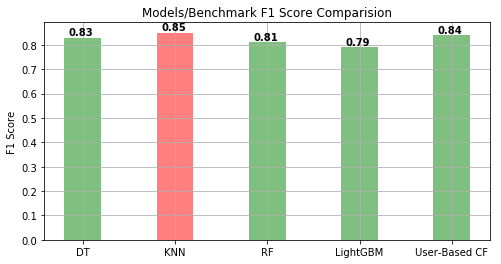

In [211]:
# Plotting the highest F1 scores obtained by my four models against the F1 score obtained by the bench mark model "user based collaborative filtering

models=('DT','KNN','RF','LightGBM','User-Based CF')
width = 0.40       # the width of the bars
y_pos = np.arange(len(models))
plt.bar(y_pos, f1scores, width,align='center', color= ['g'if x<max(f1scores) else 'r' for x in f1scores] ,alpha=0.5)
plt.grid()
plt.xticks(y_pos, models)
plt.ylabel('F1 Score')
plt.title('Models/Benchmark F1 Score Comparision')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size 
plt.savefig('model_benchmark_f1score') 

for i, v in enumerate(f1scores):
    plt.text(i-0.15  ,v+0.01 , str(v), color='black', fontweight='bold')
plt.show()





In [490]:
# Printing the models sorted in descending order based on the achieved F1 Score
models=list(models)
sorted_f1scores,sorted_models=[list(x) for x in zip(*sorted(zip(f1scores, models), key=lambda pair: pair[0]))]
print("Printing the models starting with the model that has the highest F1 Score and ending with the one that has the least")
for x,y in zip(reversed(sorted_models),reversed(sorted_f1scores)):
    print(x, y) 
    
    

Printing the models starting with the model that has the highest F1 Score and ending with the one that has the least
('KNN', 0.85)
('User-Based CF', 0.84)
('DT', 0.83)
('RF', 0.81)
('LightGBM', 0.79)


In [ ]:
# The end